In [1]:
# https://github.com/42io/dataset/tree/master/google_speech_commands#numpy-example
DATASET_FILE = '1gmnWx2we0I-RNiWSvIRN7RzUrJrSp_uQ' # 0-9up.npz

In [2]:
!test -f "$DATASET_FILE" || sudo pip install gdown

In [3]:
!test -f "$DATASET_FILE" || gdown --id "$DATASET_FILE" -O "$DATASET_FILE"

In [4]:
import subprocess
assert(b'cb126d837b86b1f6baf5c8268804877a' == subprocess.run(['md5sum', DATASET_FILE], stdout=subprocess.PIPE).stdout.split()[0])

In [5]:
import numpy as np
from tensorflow import keras as keras

In [6]:
dset = np.load(DATASET_FILE)
print(dset['x_train'].shape)

(1095480, 637)


In [7]:
x_train_3d = dset['x_train'].reshape(len(dset['x_train']), 49, 13)
x_test_3d = dset['x_test'].reshape(len(dset['x_test']), 49, 13)
x_valid_3d = dset['x_valid'].reshape(len(dset['x_valid']), 49, 13)

In [8]:
model = keras.Sequential()
model.add(keras.layers.LSTM(32, return_sequences=True, unroll=True, input_shape=(49,13)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, return_sequences=True, unroll=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, unroll=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(12, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=25,
        restore_best_weights=True)

history = model.fit(x_train_3d,
                    keras.utils.to_categorical(dset['y_train']),
                    validation_data=(x_valid_3d, keras.utils.to_categorical(dset['y_valid'])),
                    callbacks=[early_stopping],
                    verbose=2,
                    epochs=150)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 49, 32)            5888      
_________________________________________________________________
dropout (Dropout)            (None, 49, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 49, 32)            8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                3

In [9]:
results = model.evaluate(x_train_3d, keras.utils.to_categorical(dset['y_train']), verbose=0)
print('train loss, train acc:', results)

results = model.evaluate(x_test_3d, keras.utils.to_categorical(dset['y_test']), verbose=0)
print('test loss, test acc:', results)

results = model.evaluate(x_valid_3d, keras.utils.to_categorical(dset['y_valid']), verbose=0)
print('valid loss, valid acc:', results)

train loss, train acc: [0.05820419872268596, 0.9808367]
test loss, test acc: [0.12940239246784913, 0.96236414]
valid loss, valid acc: [0.08010162045812301, 0.97684085]


In [10]:
assert(len(x_test_3d) + len(x_valid_3d) == 7141)
pred = model.predict_classes(x_test_3d)
print(np.sum(pred != dset['y_test']), len(pred))
pred = model.predict_classes(x_valid_3d)
print(np.sum(pred != dset['y_valid']), len(pred))

142 3773
78 3368


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


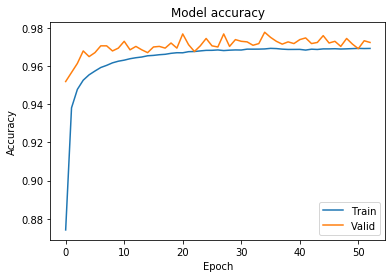

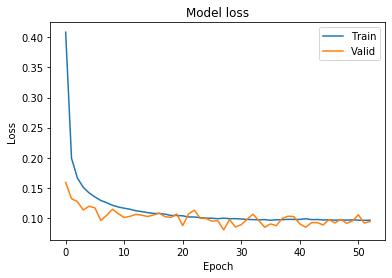

In [11]:
print(history.history.keys())

%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [12]:
import tensorflow as tf
print(tf.__version__)

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

2.1.0


In [13]:
!mkdir -p './models'
with open("./models/rnn.tflite", "wb") as f:
  f.write(tflite_model)
!md5sum ./models/rnn.tflite

f421cfd0b9f2599f89980c608383b2d9  ./models/rnn.tflite
